# Recommendation System Project: IBM Community

In this notebook, recommendation skills has been put into practice to use on real data from the IBM Watson Studio platform. 

The table of contents, lists the portions in this notebook where I have built a number of different methods for making recommendations that can be used for different situations. 


#### Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank-Based-Recs)<br>
III. [User-User Based Collaborative Filtering](#User-User-Recs)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

##### Proceeding with imports and data load and data explainations.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
# Setting this flag to execute Experimental Cells in the notebook
# You can set it to False to disable the Experimental Cells
# This flag is not used in the actual project code.
# It is only used to control the execution of Experimental Cells in the notebook.
# You can ignore it.
exp=False

df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# 
# display(df["Unnamed: 0"].value_counts())
# Show df to get an idea of the data
display(df.head())
display(df.info())

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


None

#### Notes
- The data file provide information about comment titles of various users (identified by an encripted email) for a given article. Data has four fields    
    - "Unnamed: 0": This field is the index for each row.  
    - "article_id": Numeric field contains the ID of the article for which a user has commented. 
    - "title": The title of the comment 
    - "email": Encrypted email of the use who has commented for the given article.   

## <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

##### Questions and actions
`1.` Check if there are any missing values? If yes, which field and what is the count of missing values.  
Action: For missing values in `email`, assign the same id value `"unknown_user"`.

In [3]:
nulls = df.isna().sum()[df.isna().sum() > 0]
print(f"Field '{nulls.index[0]}' have total null values = {nulls.iloc[0]}")

Field 'email' have total null values = 17


In [4]:
# Some interactions do not have a user associated with it, assume the same user.
# Fill email NaNs with "unknown_user"
df.fillna({"email":"unknown_user"}, inplace=True)
print(f"Total null values filled for 'email' = {df.email.value_counts().filter(like="unknown_user").iloc[0]}")

Total null values filled for 'email' = 17


In [5]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [6]:
# What are the descriptive statistics of the number of articles a user interacts with?
user_interaction = df.groupby('email')['article_id'].count().sort_values(ascending=False)
UInter = user_interaction.describe().apply(lambda x: format(x, '0.2f'))
UInter
print("Descriptive statistics of user-article interactions:")
print(f"\t50% of individuals have {UInter['50%']} or fewer interactions.")
print(f"\tUser-Article interactions: Max by any user is: {UInter['max']}")
print(f"\tUser-Article interactions: Mean and Standard Deviations are: {UInter['mean']} and {UInter['std']} respectively")
print(f"\tThe number of users that interact with articles is {user_interaction.shape[0]}")
print(f"\tThe number of unique articles that have been interacted with is: {df['article_id'].nunique()}")
print(f"\tThe total number of user-article interactions is: {df.shape[0]}")   

Descriptive statistics of user-article interactions:
	50% of individuals have 3.00 or fewer interactions.
	User-Article interactions: Max by any user is: 364.00
	User-Article interactions: Mean and Standard Deviations are: 8.93 and 16.80 respectively
	The number of users that interact with articles is 5149
	The number of unique articles that have been interacted with is: 714
	The total number of user-article interactions is: 45993


bins:[  1.   13.1  25.2  37.3  49.4  61.5  73.6  85.7  97.8 109.9 122.  134.1
 146.2 158.3 170.4 182.5 194.6 206.7 218.8 230.9 243.  255.1 267.2 279.3
 291.4 303.5 315.6 327.7 339.8 351.9 364. ]


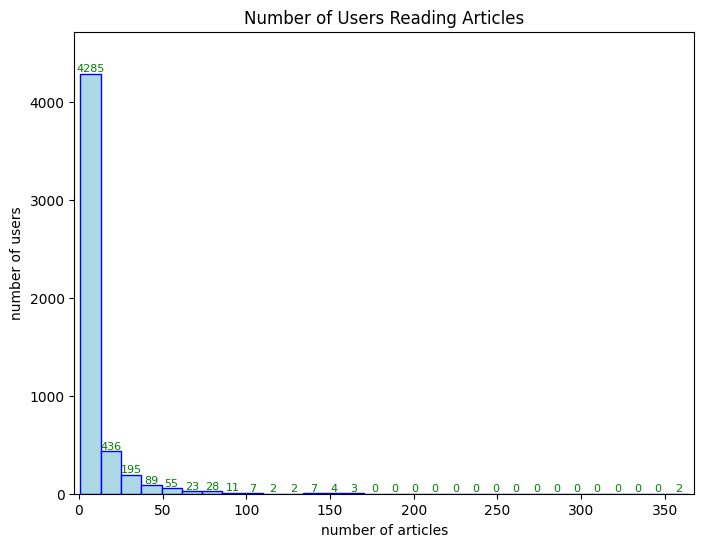

In [7]:
# Create a plot of the number of articles read by each user
plt.figure(figsize=(8,6))
# user_interaction.plot(kind='hist')
values, bins, bars = plt.hist(user_interaction, edgecolor='blue', color='lightblue', bins=30)
print(f"bins:{bins}")
plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')
plt.bar_label(bars, fontsize=8, color='green')
plt.margins(x=0.01, y=0.1)
plt.show()

In [8]:
article_interaction=df.groupby('article_id')['email'].count()
AInter = article_interaction.describe().apply(lambda x: format(x, '0.2f'))
AInter
print("Descriptive statistics of article-user interactions:")
print(f"\t50% of articles were interacted with {AInter['50%']} or fewer times.")
print(f"\tArticle interactions: Max for an article is: {AInter['max']}")
print(f"\tArticle interactions: Mean and Standard Deviations are: {AInter['mean']} and {AInter['std']} respectively")
print(f"\tThe number of unique articles that have been interacted with is: {df['article_id'].nunique()}")
print(f"\tThe total number of user-article interactions is: {df.shape[0]}")   

Descriptive statistics of article-user interactions:
	50% of articles were interacted with 25.00 or fewer times.
	Article interactions: Max for an article is: 937.00
	Article interactions: Mean and Standard Deviations are: 64.42 and 109.18 respectively
	The number of unique articles that have been interacted with is: 714
	The total number of user-article interactions is: 45993


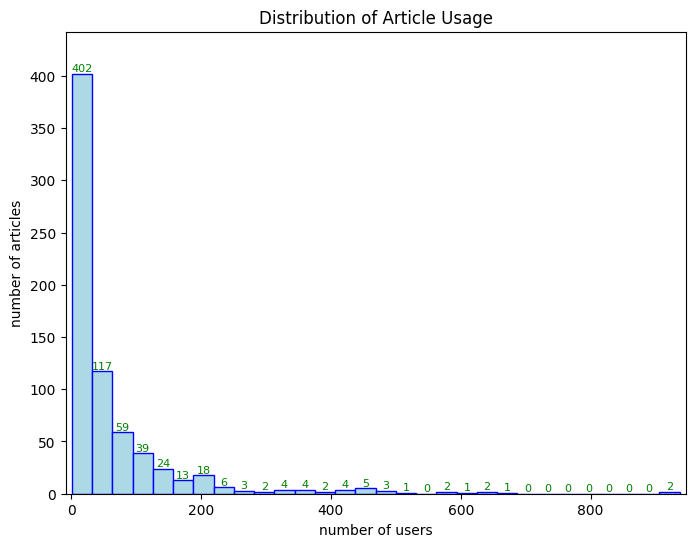

In [9]:
# Create a plot of the number of times each article was read
plt.figure(figsize=(8,6))
# article_interaction.plot(kind='hist')
values, bins, bars = plt.hist(article_interaction, edgecolor='blue', color='lightblue', bins=30)
plt.xlabel('number of users')
plt.ylabel('number of articles')
plt.title('Distribution of Article Usage')
plt.bar_label(bars, fontsize=8, color='green')
plt.margins(x=0.01, y=0.1)

plt.show()

In [10]:
# Fill in the median and maximum number of user_article interactions below

median_val = float(UInter["50%"]) # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =  float(UInter["max"])# The maximum number of user-article interactions by any 1 user is ______.
print(median_val,max_views_by_user)

3.0 364.0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
unique_articles =  df[df.email != "unknown_user"].article_id.nunique()# The number of unique articles that have at least one interaction
total_articles = df.article_id.nunique() # The number of unique articles on the IBM platform
unique_users =  df.email.nunique() # The number of unique users
user_article_interactions =  df.shape[0]# The number of user-article interactions
unique_articles,total_articles,unique_users, user_article_interactions

(714, 714, 5149, 45993)

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
# The most viewed article in the dataset as a string with one value following the decimal point (e.g. '1024.0', '523.0', etc.)
most_viewed_article_id =  float(df.article_id.value_counts().index[0])
# The most viewed article in the dataset was viewed how many times?
max_views =  df.article_id.value_counts().iloc[0] 
most_viewed_article_id, int(max_views)

(1429.0, 937)

In [13]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
# del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,email,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,1
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,2
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,3
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,4
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,5


In [14]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


## <a class="anchor" id="Rank-Based-Recs">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Below function returns the **n** top articles ordered with most interactions as the top. 

`2.` Function tested using the tests defined in the cell down below.

In [15]:
##### Experiment Cell 
if exp:
    n=2;
    print(f"Top {n} Titles {df['title'].value_counts()[:n].index.to_list()}") 
    print(f"Top {n} Article IDs {df['article_id'].value_counts()[:n].index.to_list()}") 

In [16]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    top_articles = df['title'].value_counts()[:n].index.to_list()
    
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article IDs 
    
    """
    top_articles = df['article_id'].value_counts()[:n].index.to_list()
 
    return top_articles # Return the top article ids

In [17]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [18]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)
# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


## <a class="anchor" id="User-User-Recs">Part III: User-User Based Collaborative Filtering</a>


`1.` Below function is written to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** only appear in each **row** once.


* Each **article** only show up in one **column**.  


* **If a user has interacted with an article, then values is 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Used the tests to make sure the basic structure the matrix matches what is expected by the solution.

In [19]:
########## Experiment cell - User-Item Matrix
if exp:
    # create a new df based on count of articles for each combination of user-article
    df_count = df.groupby(['user_id', 'article_id'])["title"].count().reset_index() 
    # display(df_count)
    # # Now pivot the DF to put users on rows and article on columns
    user_item = df_count.pivot_table(values='title', index='user_id', columns='article_id', aggfunc="count") 
    # replace nulls with 0s
    user_item.replace(np.nan, 0, inplace=True) 
    # entries should be a 1 or 0
    user_item=user_item.map(lambda x: 1 if x > 0 else int(x)) 
    display(user_item)

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    """
    # Fill in the function here
    #Step 1: Create a DF by grouping  user_id and article ids and counting the number of titles for each combination. 
    # Using reset index to get a proper dataframe rows.  
    data_count = df.groupby(['user_id', 'article_id']).count().reset_index()
    #Step 2: Creating a Matrix (Pivot Table) from the count dataframe with sum of title counts as value
    user_item = data_count.pivot_table(values='title', index='user_id', columns='article_id',aggfunc="sum")
    # The #NAN will be reported for all combinations of user_id and article_id, where there are no interactions
    #Step 3: replace #NAN by 0 indicating no interactions. 
    user_item.replace(np.nan, 0, inplace=True)
    #Step 4: Update the martix 
    # by replacing all values >=1 to 1 indicating one or more interactions has happened, and 
    # keep rest as zero. Also change the values to Int. 
    user_item = user_item.map(lambda x: 1 if x>=1 else int(x))
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
display(
user_item.shape, 
user_item.sum(axis=0).sort_values(ascending=False)[:3],
user_item.sum(axis=1).sort_values(ascending=False)[:3]
)

(5149, 714)

article_id
1330    467
1429    397
1364    388
dtype: int64

user_id
3782    135
23      135
49      101
dtype: int64

In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` The function below takes a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result does not contain the provided user_id, as we know that each user is similar to him/herself.  

I have used `cosine_similarity` function from sklearn 

Used the tests to test the function.

In [22]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
### Experiment Cell - User-User Similarity
###
if exp:
    cos_sim_users = pd.DataFrame(cosine_similarity(user_item),index=user_item.index,columns=user_item.index)
    # display(cos_sim_users)
    cos_sim_users.shape
    # display(dp_users)
    user_id=1
    sim_users = cos_sim_users[user_id].sort_values(ascending=False)[1:]

    display(
        sim_users, 
        [list(p) for p in sim_users.items()],
        # list(zip(sim_users.index,sim_users.values.tolist()))
    )


In [26]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (cosine similar users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on cosine similarity.
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.
    
    """
    
    # compute similarity of each user to the provided user
    cos_sim_users = pd.DataFrame(cosine_similarity(user_item),index=user_item.index,columns=user_item.index)


    # sort by similarity
    similar_users = cos_sim_users[user_id].sort_values(ascending = False)

    # remove the own user's id
    similar_users = similar_users[1:]

    # create list of just the ids
    most_similar_users = similar_users.index.to_list()
    
    # create list of just the similarities
    most_user_similarity = list(similar_users.values.tolist())
    
    if include_similarity:
        return [list(p) for p in similar_users.items()]# return a list of lists with [[similar_user_id, similarity], ...]
    return most_similar_users # return a list of the users in order from most to least similar
        

In [27]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))
print("\t(with similarity score) : {}".format(find_similar_users(46,include_similarity=True)[:3]))


The 10 most similar users to user 1 are: [3933, 4201, 46, 5034, 253, 824, 5041, 2305, 136, 395]
The 5 most similar users to user 3933 are: [1, 46, 4201, 5034, 253]
The 3 most similar users to user 46 are: [4201, 790, 5077]
	(with similarity score) : [[4201, 1.0000000000000002], [790, 0.38138503569823695], [5077, 0.36273812505500586]]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [28]:
### Experiment Cell - User Based Recommender
if exp:
    article_ids = [844, 232, 1320]
    # article_names = [df[df['article_id']==float(idx)].max()['title'] for idx in article_ids]
    article_names = df[df['article_id'].isin(article_ids)][['title']].drop_duplicates().values.flatten().tolist()
    print(f"Article Names : {len(article_names)} {article_names} ")
    user_id=2
    display(
    user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype('int')
    )

In [29]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    # Your code here
    # Filter titles from df for article_ids, drop duplicates, fetch values, flatten the list of list and convert to list 
    article_names = df[df['article_id'].isin(article_ids)][['title']].drop_duplicates().values.flatten().tolist()
    
    return article_names # Return the article names associated with list of article ids

def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    article_ids - (list) a list of article_id 
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise 
    
    OUTPUT:
    article_counts - (list) a list of tuples with article_id and number of 
                     unique users that have interacted with the article, sorted
                     by the number of unique users in descending order
    
    Description:
    Provides a list of the article_ids and the number of unique users that have
    interacted with the article using the user_item matrix, sorted by the number
    of unique users in descending order
    """
    # Your code here
    # Sum the number of users for each article in the provided list of article_ids, and sort the result in descending order 
    
    sorted_article_counts = user_item[article_ids].sum(axis=0).sort_values(ascending=False)
    
    ranked_article_unique_counts = [list(p) for p in sorted_article_counts.items()]
    return ranked_article_unique_counts


def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Your code here
    # get the article ids where user has interactions
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype('int')
    # for article_names, use the get_article_names function defined earlier
    article_names = get_article_names(article_ids,df=df)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    """
    # Your code here
    recs = np.array([]) # recommendations to be made
    
    user_articles_seen = get_user_articles(user_id)[0] #seen by our user
    closest_users = find_similar_users(user_id) # users closest to our user
    
    for others in closest_users:
        
        others_articles_seen = get_user_articles(others)[0] # articles seen by others like our user
        # using `np.setdiff1d` to find the set difference of two arrays. (looks for values in first array that are not in second array)
        new_recs = np.setdiff1d(others_articles_seen, user_articles_seen, assume_unique=True) 
        # Add new recommendations to recs array and keep only unique values as other users may have seen same articles
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0)) 
        if len(recs) >=m:
            break
            
    recs = recs[:m]
    recs.tolist()
    
    return recs # return recommendations for given user_id    

In [30]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['leverage python, scikit, and text classification for behavioral profiling',
 'challenges in deep learning',
 'awesome deep learning papers',
 'this week in data science (april 18, 2017)',
 'improving the roi of big data and analytics through leveraging new sources of data',
 'this week in data science (may 2, 2017)',
 'using apply, sapply, lapply in r',
 'how can data scientists collaborate to build better business',
 'top 20 r machine learning and data science packages',
 'do i need to learn r?']

In [31]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [32]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [33]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe, i.e. Descending order
     
    """
    # Your code here
    # Hint: find similar users, but include their similarity, from there we can find the number of interactions for each neighbor
    # Compute the cosine similarity matrix
    similarity_matrix = cosine_similarity(user_item)
    # user_idx = 
    similarity_scores = similarity_matrix[user_item.index.get_loc(user_id)]
    # Count interactions
    num_interactions = user_item.sum(axis=1)

    # Build DataFrame
    neighbors_df = pd.DataFrame({
        'neighbor_id': user_item.index,
        'similarity': similarity_scores,
        'num_interactions': num_interactions
    })

    # Remove the provided user from the results
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]

    # Sort by similarity and then number of interactions
    neighbors_df = neighbors_df.sort_values(
        by=['similarity', 'num_interactions'], ascending=False).reset_index(drop=True) 
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    """
    # Your code here

    #########################
    # Articles seen by the user
    seen_article_ids = get_user_articles(user_id)[0]

    # Find similar users sorted by similarity and interactions
    neighbors_df = get_top_sorted_users(user_id)

    recs = []
    
    for neighbor_id in neighbors_df['neighbor_id']:
        neighbor_articles = get_user_articles(neighbor_id)[0]
        # Find articles not seen by user_id and at already in recs
        new_recs = [ rec for rec in neighbor_articles if rec not in seen_article_ids and rec not in recs]
        recs.extend(new_recs)
        if len(recs) >= m:
            break

    # Rank recommended articles by total interactions
    if len(recs) > m:
        ranked_recs = get_ranked_article_unique_counts(recs)
        recs = [str(article_id) for article_id, _ in ranked_recs[:m]]
    else:
        recs = [str(rec) for rec in recs]

    rec_names = get_article_names(recs)
        
    return recs, rec_names # return your recommendations for this user_id

In [34]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1162', '1165', '1185', '1293', '254', '40', '1271', '1328', '1402', '1410']

The top 10 recommendations for user 20 are the following article names:
[]


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [35]:
print(get_top_sorted_users(1, user_item=user_item).head(n=4))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013                35
1           46    0.342580                40
2         4201    0.342580                40
3          253    0.333333                 4
   neighbor_id  similarity  num_interactions
0         5083    0.730297                 5
1         1552    0.577350                 2
2         1890    0.577350                 2
3         1372    0.471405                 3
4         2941    0.433013                 8
5         3586    0.408248                 4
6          331    0.408248                 1
7          348    0.408248                 1
8          378    0.408248                 1
9          496    0.408248                 1
   neighbor_id  similarity  num_interactions
0         3870    0.986667                75
1          203    0.388909                96
2         4459    0.388909                96
3         3782    0.387585               135
4           40    0.384308                52
5         

In [36]:
### Tests with a dictionary of results
user1_most_sim =  get_top_sorted_users(1,user_item).iloc[0].neighbor_id# Find the user that is most similar to user 1 
user2_6th_sim =  get_top_sorted_users(2,user_item).iloc[5].neighbor_id# Find the 6th most similar user to user 2
user131_10th_sim =  get_top_sorted_users(131,user_item).iloc[9].neighbor_id# Find the 10th most similar user to user 131

In [37]:
print (user1_most_sim, user2_6th_sim, user131_10th_sim)

3933.0 3586.0 383.0


In [38]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

Top articles as no user history, only can use user-user history till they start having user-item iteractions

`7.` Using the existing functions, provide the top 10 recommended articles for the a new user below.  Test assertion passes well and assures that we are all on the same page with how we might make a recommendation.

In [39]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df) # Your recommendations here




In [40]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


## <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Function bodies below are used to create a content based recommender function `make_content_recs`. I have used TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. This function can be used to make recommendations of new articles.

In [41]:
df.head()

,Unnamed: 0,article_id,title,email,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,1
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,2
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,3
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,4
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,5


In [42]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [43]:
# unique articles
df_unique_articles = df[df.article_id.duplicated()]
df_unique_articles.shape

(45279, 5)

In [44]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf =  vectorizer.fit_transform(df_unique_articles['title'],)# Fit the vectorizer to the article titles
print(type(X_tfidf))
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)# Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
<class 'scipy.sparse._csr.csr_matrix'>
n_samples: 45279, n_features: 200
Explained variance of the SVD step: 71.7%


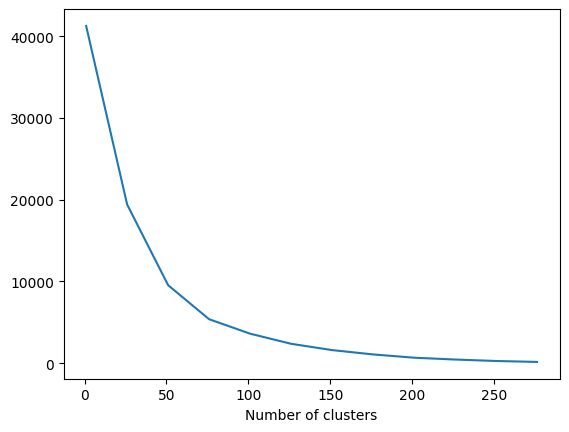

In [45]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters');

There appears to be an elbow about 50, so we'll use 50 clusters.

In [46]:
n_clusters = 50 # Number of clusters
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state
).fit(X_lsa)

In [47]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df
# Map article_id to cluster label using df_unique_articles and kmeans.labels_
article_cluster_map = dict(zip(df_unique_articles['article_id'], kmeans.labels_))
# Assign the cluster label to each row in df based on article_id
df['title_cluster'] = df['article_id'].map(article_cluster_map)

In [48]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[   0,  796],
       [   1, 1581],
       [   2,  936],
       [   3, 3624],
       [   4,  776],
       [   5,  681],
       [   6, 2248],
       [   7, 1713],
       [   8, 1253],
       [   9,  995],
       [  10,  787],
       [  11, 1776],
       [  12,  963],
       [  13, 1165],
       [  14,  935],
       [  15, 1166],
       [  16,  906],
       [  17,  604],
       [  18,  708],
       [  19, 1060],
       [  20, 1067],
       [  21,  730],
       [  22,  619],
       [  23,  803],
       [  24,  587],
       [  25,  629],
       [  26, 1215],
       [  27,  791],
       [  28,  456],
       [  29,  591],
       [  30,  441],
       [  31, 1285],
       [  32,  795],
       [  33,  471],
       [  34,  680],
       [  35,  528],
       [  36,  472],
       [  37,  614],
       [  38, 1292],
       [  39,  378],
       [  40,  500],
       [  41,  448],
       [  42,  483],
       [  43,  652],
       [  44,  417],
       [  45,  441],
       [  46,  913],
       [  47,

In [49]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
    # Your code here
    # Get the cluster for the given article_id
    title_cluster = df.loc[df['article_id'] == article_id, 'title_cluster'].values[0]
    # Get all article_ids in the same cluster
    articles_in_cluster = df[df['title_cluster'] == title_cluster]['article_id'].unique().tolist()
    # Remove the input article_id from the list
    articles_in_cluster = [aid for aid in articles_in_cluster if aid != article_id]
    
    return articles_in_cluster

In [50]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    
    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    # Your code here 
    # Get similar articles in the same cluster (excluding the input article)
    similar_article_ids = get_similar_articles(article_id, df)

    # Rank similar articles by popularity (number of unique users)
    ranked_similar_articles = get_ranked_article_unique_counts(similar_article_ids)

    # Take the top n article ids
    n_ranked_similar_articles = [article_id for article_id, _ in ranked_similar_articles[:n]]

    # Get the article names for these ids
    n_ranked_article_names = get_article_names(n_ranked_similar_articles, df)
    return n_ranked_similar_articles, n_ranked_article_names
        

In [51]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1025, 237, 593, 173, 349, 101, 821, 975, 766, 508]
['upload files to ibm data science experience using the command line', '10 must attend data science, ml and ai conferences in 2018', 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics', 'deep learning with data science experience', 'data science in the cloud', 'making data science a team sport', 'how to choose a project to practice data science', 'data tidying in data science experience', 'the data science process', 'using rstudio in ibm data science experience']


In [52]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."
print("If this is all you see, you passed the test!  Nice job!")

If this is all you see, you passed the test!  Nice job!


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**
Content based recommendation system make use of NLP to get latent features from the text data (which is `title` here), these latent features help getting recommendations based on content similarity what a user's interactions looks like. 
K-MEAN clustering is used with data having latent features here. 

## <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` We will use a already created **user_item** matrix in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [53]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [54]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

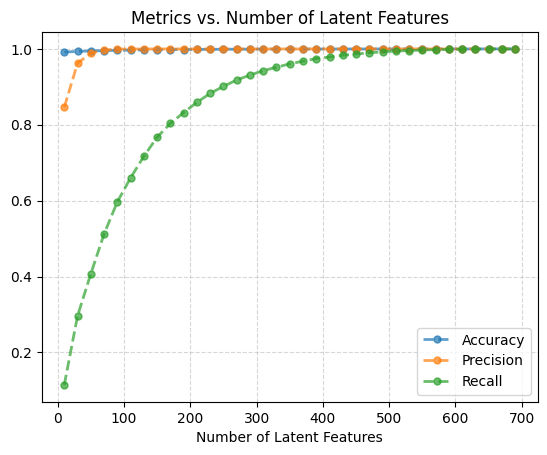

In [55]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'], marker='o', markersize=5, linestyle='--', linewidth=2, alpha=0.7)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**
Above graph indicate that the Accuracy and Precision are pretty much flat after around 100 features. So we have only recall that can give some indication of selection number of latent features here. And the Recall graph kind of loosing its growth after reaching 80% or so, that gives an indication that an optimal count of latent features here could be around 200. 

##### The logic to decide the optimal number of latent features from the Accuracy-Precision-Recall graph is:

- **Look for the "elbow" point**: As the number of latent features increases, all metrics (accuracy, precision, recall) improve rapidly at first, then the improvement slows down and the curves flatten out. The "elbow" or inflection point is where adding more features yields diminishing returns.
- **Balance recall and precision**: Choose a feature count where both recall and precision are high and stable. Often, recall increases more slowly than precision, so you may want to pick a value where recall is maximized without sacrificing much precision.
- **Avoid overfitting**: Too many features may overfit the training data and not generalize well. The optimal point is usually just before the metrics plateau.

**In practice:**  
Pick the smallest number of latent features after which the increase in accuracy, precision, or recall becomes minimal (the curves flatten). This gives you a good trade-off between model complexity and performance.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [56]:
from sklearn.metrics.pairwise import cosine_similarity

def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids similar using SVD factorization
    """
    # Find the index of the article_id
    # Find the index of the article_id in the user_item columns
    article_idx = list(user_item.columns).index(article_id)
    # Compute cosine similarity between articles (columns of vt)
    cos_sim = cosine_similarity(vt.T)
    # Get similarities for the given article
    sim_scores = cos_sim[article_idx]
    # Get indices of articles sorted by similarity (descending), exclude itself
    sorted_idx = sim_scores.argsort()[::-1]
    # Exclude the article itself
    sorted_idx = [i for i in sorted_idx if i != article_idx]
    # Map indices back to article_ids
    most_similar_items = [user_item.columns[i] for i in sorted_idx]
    if include_similarity:
        return [[user_item.columns[i], sim_scores[i]] for i in sorted_idx]
    return most_similar_items

In [57]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [58]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [59]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[np.int64(1199),
 np.int64(1068),
 np.int64(486),
 np.int64(1202),
 np.int64(176),
 np.int64(1120),
 np.int64(244),
 np.int64(793),
 np.int64(58),
 np.int64(132)]

In [60]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['use spark r to load and analyze data',
 'collecting data science cheat sheets',
 '10 powerful features on watson data platform, no coding necessary',
 'notebooks: a power tool for data scientists',
 'country statistics: crude oil - proved reserves',
 'country statistics: crude oil - exports',
 'top analytics tools in 2016',
 'advancements in the spark community',
 'airbnb data for analytics: paris calendar',
 'airbnb data for analytics: athens reviews']

In [61]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Your response here.**
**Section 2** uses simple method of Top popular articles, and can be useful for new user's cases where we do not have any reference for user's preferences 

**Section 3** uses the user similarity, based on similar articles where other users had also interacted and making prediction based on that similar user's interactions and preferences. This is very good way to know how similar two users preferences could be. This can be useful, even if we user has small number of interactions, user neighbor pairing can bring good results. 

**Section 4** used content based similarity among user, not only the commonly interacted article base, like in section 2. This gives further refined recommendation to those articles which have similar title of the article (based on text vectorization, SVD etc.) Those article which are seen by the similar users but does not match with text similarity of the user, will not be part of recommendation. This can bring breat improvement in the recommendation system and becomes more contexual for the user. THis method can give betters results for users with lots of history of interacting with articles, as previous method will not filterout the contexual recommendations. 




## <a id='conclusions'> Extras</a>


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [62]:
from subprocess import call

def convert_notebook_to_(notebook,toFormat="html"):
    """
    Converts the Jupyter notebook to an HTML file.
    """
    import os
    call(['python3', "-m", 'nbconvert', '--to', toFormat, notebook])
convert_notebook_to_('Recommendations_with_IBM.ipynb',toFormat="html")
# convert_notebook_to_('Recommendations_with_IBM.ipynb',toFormat="pdf")
# !python3 -m nbconvert --to html Recommendations_with_IBM.ipynb

[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 661846 bytes to Recommendations_with_IBM.html
